<a href="https://colab.research.google.com/github/BoshiLee/pytorch_learning/blob/main/iris_adagrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package and dataset

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from sklearn import datasets
from torch.utils.data import Dataset

In [3]:
iris_data = datasets.load_iris()
input_data = iris_data.data
target = iris_data.target

n_data = len(target)

## Target To hot-laybel format

In [4]:
target


def to_hot_label(t):
  temp = np.zeros((len(t), 3))
  for i in range(len(t)):
    temp[i, t[i]] = 1
  return torch.tensor(temp)

target_data = to_hot_label(target)


# Normalization 歸一

(樣本 - 樣本平均值) / 標準差

In [5]:
from numpy.ma.extras import median
mean_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)

input_data = (input_data - mean_input) / std_input

## Define hyper parameters

In [6]:
n_in = 4 # 輸入
n_mid = 25 # 中間層
n_out = 3 # 輸出

wb_width = 0.1 #
eta = 0.01 # 學習率
epochs = 1000
batch_size = 8
interval = 100


## Apart Datasets to Test and Training

In [7]:
all_idx = np.arange(n_data)
index_train = all_idx[all_idx % 2 == 0] # 0,2,4,6...
index_test = all_idx[all_idx % 2 != 0] # 1,3,5

input_train = input_data[index_train, :]
input_test = input_data[index_test, :]

target_train = target_data[index_train, :]
target_test = target_data[index_test, :]

## Conver raw data to torch dataset




In [8]:
class IrisDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X                           # set data
        self.Y = Y                           # set lables

    def __len__(self):
        return len(self.X)                   # return length

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]] 

In [9]:
training_dataset = IrisDataset(input_train, target_train)
validation_dataset = IrisDataset(input_test, target_test)

## Define Iterable Loader
one for training
another for validation

In [10]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size =batch_size, shuffle=False)

## Define Model

In middle layer, I chose reLU for active function and softmax for output layer to classfication model results.

In [11]:
class Model(nn.Module):
  def __init__(self, D_in, H1, D_out):
    super().__init__();
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H1)
    self.linear3 = nn.Linear(H1, D_out)
  
  def forward(self, x):
    x = F.relu(self.linear1(x)) # 輸入位給第一層 hidden layer 後再將輸出給下一層用
    x = F.relu(self.linear2(x)) # 輸入位給第二層 hidden layer 給輸出曾使用
    x = self.linear3(x) # 這裡不用 softmax 去做分類，課程是說等等可以用原始輸出給 nn.CrossEntropyLoss
    return x.float()

## Initail Model

In [12]:
model = Model(n_in, n_mid, n_out) 
model

Model(
  (linear1): Linear(in_features=4, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=25, bias=True)
  (linear3): Linear(in_features=25, out_features=3, bias=True)
)

## Initial Loss function and optimizer
# 在這裡改成使用 Adagrad

Adagrad 的優缺點

![](https://imgur.com/Uo3QDLy.jpg)

優點
當 t 持續增加，σ 項會約束梯度，也就是說，Adagrad 可以自動調整 learning rate 直至收斂。
適合處理稀疏梯度


缺點
當後期 
σ t 值很大的時候，整個梯度會被約束到趨近於 0 ，導致訓練提前結束。仍然需要先設置一個全局學習率 
η，且其大小仍然會影響訓練的過程。


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr = eta)

## Start Training

In [14]:
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

def validation_process():
  val_acc = 0.0
  corrects = 0.0
  with torch.no_grad():
    for (val_inputs, val_labels) in validation_loader:
      val_inputs = val_inputs.view(val_inputs.shape[0], -1) # 如果是torch.view(a, -1)，则原张量会变成一维的结构。
      val_outputs = model.forward(val_inputs.float())
      val_loss = criterion(val_outputs, val_labels) #loss function
      val_loss += val_loss.item() # 將每一訓練完的結果加回總數


      _, val_preds = torch.max(val_outputs, dim=1) #返回每一列中最大值的那个元素，且返回索引（返回最大元素在这一列的行索引）
      val_preds = to_hot_label(val_preds)
      val_acc = torch.sum(torch.argmax(val_preds, dim=1) == torch.argmax(val_labels, dim=1))
      corrects += (val_acc / len(val_labels))
    return val_loss, corrects

def record_epoch(title:str, losses, corrects, loader_lenth):
  epoch_loss = losses / loader_lenth # 將損失總數除上一個 batch 的資料總數就可以到此次 batch 訓練出來損失多少
  epoch_accuracy = corrects.float() / loader_lenth

  print(title + " loss: {:.4f}".format(epoch_loss))
  print(title + " accuracy: {:.4f}".format(epoch_accuracy.item()))

  return epoch_loss, epoch_accuracy


def traing_process(epoch):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for (inputs, labels) in training_loader:
    outputs = model.forward(inputs.float())
    loss = criterion(outputs, labels) #loss function
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs, dim=1) #返回每一列中最大值的那个元素，且返回索引（返回最大元素在这一列的行索引）
    preds = to_hot_label(preds)
    acc = torch.sum(torch.argmax(preds, dim=1) == torch.argmax(labels, dim=1))
    running_loss += loss.item() # 將每一訓練完的結果加回總數
    running_corrects += (acc / len(labels))
  else:
    print("epoch: ", epoch + 1)
    training_epoch_loss, training_epoch_accuracy = record_epoch(
        title="Training",
        losses=running_loss,
        corrects=running_corrects,
        loader_lenth=len(training_loader)
        )
    
    running_loss_history.append(training_epoch_loss)
    running_correct_history.append(training_epoch_accuracy)
    
    val_running_loss, val_running_corrects = validation_process()
    val_epoch_loss, val_epoch_accuracy = record_epoch(
        title='Validation',
        losses=val_running_loss,
        corrects=val_running_corrects,
        loader_lenth=len(validation_loader)
        )
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_epoch_accuracy)

for e in range(epochs):
  traing_process(e)

epoch:  1
Training loss: 0.9087
Training accuracy: 0.6667
Validation loss: 0.2098
Validation accuracy: 0.6500
epoch:  2
Training loss: 0.7085
Training accuracy: 0.7375
Validation loss: 0.1802
Validation accuracy: 0.8667
epoch:  3
Training loss: 0.5741
Training accuracy: 0.9500
Validation loss: 0.1625
Validation accuracy: 0.9042
epoch:  4
Training loss: 0.4924
Training accuracy: 0.9375
Validation loss: 0.1462
Validation accuracy: 0.9500
epoch:  5
Training loss: 0.4537
Training accuracy: 0.9375
Validation loss: 0.1265
Validation accuracy: 0.9625
epoch:  6
Training loss: 0.4081
Training accuracy: 0.9125
Validation loss: 0.1075
Validation accuracy: 0.9750
epoch:  7
Training loss: 0.3718
Training accuracy: 0.9250
Validation loss: 0.1041
Validation accuracy: 0.9625
epoch:  8
Training loss: 0.3511
Training accuracy: 0.9250
Validation loss: 0.0986
Validation accuracy: 0.9625
epoch:  9
Training loss: 0.3304
Training accuracy: 0.9292
Validation loss: 0.0847
Validation accuracy: 0.9750
epoch:  10

## Loss diagram

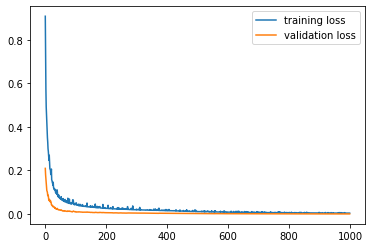

In [15]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

## Accuracy

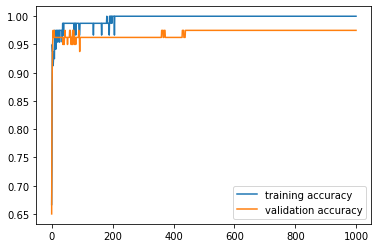

In [16]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()
plt.show()